In [1]:
import math
import random
import pandas as pd
import numpy as np

from IPython.display import clear_output
from tqdm.notebook import tqdm

In [2]:
seed = 61
random.seed(seed)
np.random.seed(seed)

In [3]:
import os
from typing import Annotated, Sequence, TypedDict, List, Dict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage 
from langchain_core.messages import ToolMessage 
from langchain_core.messages import SystemMessage 
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchRun, Tool
from tavily import TavilyClient

## Загрузка данных

In [4]:
data = pd.read_json("data_final_for_dls_new.jsonl", lines=True)
data.columns = ['text', 'address', 'name', 'norm_name_ru', 'permalink', 'prices_summarized', 'relevance', 'reviews_summarized', 'relevance_new']
train_data = data[570:]
eval_data = data[:570]
train_data = train_data[train_data["relevance"] != 0.1].reset_index(drop=True)
eval_data = eval_data[eval_data["relevance"] != 0.1].reset_index(drop=True)

Проводилась небольшая подготовка данных. В колонку `summarized` объединялись данные из 'norm_name_ru', 'prices_summarized', 'reviews_summarized'. "Лишние" колонки затем удалялись, для более удобного восприятия и отображения датасета.  
Также из колонки reviews_summarized удалялись данные после "общей" информации об организации. Это делалось, во-первых, поскольку в подавляющем большинстве случаев это была малополезная инфо без конкретики, во-вторых, чтобы стимулировать агента проверять инфо в интернете.

In [5]:
eval_data['reviews_summarized'] = eval_data['reviews_summarized'].fillna(";")
eval_data['prices_summarized'] = eval_data['prices_summarized'].fillna(";")
eval_data['reviews_summarized'] = eval_data['reviews_summarized'].str.split(r'[\n|]').str[0].str.strip()
eval_data['summarized'] = (eval_data['norm_name_ru'] + ' ; ' + eval_data['prices_summarized'] + ' ; ' + eval_data['reviews_summarized'])
eval_data.drop(columns=['norm_name_ru', 'prices_summarized', 'reviews_summarized', 'permalink'], inplace=True)

In [37]:
# eval_data.to_excel('eval_data_summarized.xlsx')

In [10]:
# eval_data = pd.read_excel('eval_data_summarized.xlsx')
# eval_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
eval_data.head(2)

,text,address,name,relevance,relevance_new,summarized
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,1.0,1.0,Магазин табака и курительных принадлежностей ;...
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,0.0,0.0,Кафе ; PioNero предлагает разнообразные блюда ...


In [7]:
eval_data.shape

(500, 6)

Для проверки агента на всем тестовом наборе было решено разбить данные на 5 частей по 100 строк. Это было сделано, из за опасений, что сервис-поисковик Tavily может иметь ограничения на дневной лимит (в пробном тарифе). По этой причине данные запускались частями. А затем объединялись снова в один файл. Это не на что не влияет, просто была такая перестраховка.

In [8]:
eval_data_1 = eval_data.iloc[0:100]
eval_data_2 = eval_data.iloc[100:200]
eval_data_3 = eval_data.iloc[200:300]
eval_data_4 = eval_data.iloc[300:400]
eval_data_5 = eval_data.iloc[400:500]

In [9]:
eval_data_1.shape, eval_data_2.shape, eval_data_3.shape, eval_data_4.shape, eval_data_5.shape

((100, 6), (100, 6), (100, 6), (100, 6), (100, 6))

### Агент - gpt-4.1

**Общая концепция агента**  
1) Агент оценивает, достаточно ли ему информации для принятия решения о релевантности запроса.
2) Если инфо не достаточно, то используем инструмент для получения доп инфо (идем в граф получения доп инфо из интернета)
3)  После получения доп инфо или если инфо было достаточно идем в граф принятия решения о релевантности.
4)  Конец работы агента.

**На шаге 1**, если не достаточно инфо, LLM кратко описывает какой инфо ей не хватает и агент записывает это в один из элементов состояния (subject_of_clarification).  
**На шаге 2** агент идет в отдельный узел - add_info. В нем, на основе subject_of_clarification и других данных агент должен формировать запрос в интернет. Причем запрос должен быть "теговым", например, «Кафе Якитория меню пицца» и т.п.  
**`Важный маленький нюанс.`** По идее агент может несколько раз уточнять инфо в посковике, вновь проходить оценку достаточности и т.д. Но, т.к. у Tavily есть ограничения на пробном тарифе, тут я умышленно ограничил агента лишь одним запросом и принудительным переходом в классификацию, если запросы уже были. Это вынужденная мера, чтобы хватило лимита запросов и на тестирование и на запуск нескольких агентов.  
**На шаге 3** происходит классификация на основе имеющихся или дополученных данных.  
**В конце** работы агента мы получаем размеченный датасет. Также будут добавлены новые колонки:  
sufficiency - достаточно/недостаточно инфо было на первом этапе.  
classification - "relevant" / "irrelevant".  
additional_info - ответ поисковика Tavily.  
subject_of_clarification - какой инфо не хватало агенту на первом этапе.  
search_query - запрос агента в поисковик.  
agent_cls - бинарная метка классификации (1/0).

In [11]:
# Вызываем модель и передаем ей инструменты
load_dotenv()
model = ChatOpenAI(
    model="gpt-4.1",  # Модель
    base_url="https://api.ai-mediator.ru/v1",  # URL API
    api_key=os.getenv("OPENAI_API_KEY"),  # Ключ из переменных окружения
    temperature=0,  # 
    )

# Загружаем ключи для поисковика - TAVILY_API_KEY из .env
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY")) 

In [12]:
# Описываем состояние агента
class AgentState(TypedDict):
    user_query: str                # запрс пользователя
    organization_address: str      # 
    organization_name: str         # 
    summary: str                   # обобщенная инфо
    sufficiency: List[str]         # "ДОСТАТОЧНО" / "НЕДОСТАТОЧНО: <причина>"
    classification: str            # "relevant" / "irrelevant"
    additional_info: str           # получение доп инфо из интернета
    number_of_requests: int        # число запросов в интернет
    subject_of_clarification: str  # что требуется уточнить
    search_query: str              # поисковый запрос от LLM

В разделе ниже представлены финальные промпты, каждый из которых прошел несколько этапов улучшений.

In [13]:
# Раздел с промптами

# ПРОМПТ ДЛЯ ЗАДАЧИ ОПРЕДЕЛЕНИЯ ДОСТАТОЧНОСТИ ИНФО
SUFFICIENCY_PROMPT = SystemMessage(content="""
**Задача:** Оцени, ДОСТАТОЧНО или НЕДОСТАТОЧНО предоставленной информации об организации 
('Адрес', 'Название', 'Сводка' и 'Дополнительная информация'), чтобы уверенно понять 
ОТНОСИТСЯ или НЕ ОТНОСИТСЯ организация к 'user_query' (запросу пользователя).

**Критерии оценки:**
1. **География**  
   а) Определи, есть ли в запросе географические указания (город, район). Если город в запросе не указан → игнорируй этот пункт.
   б) Если в запросе указан город, а город в адресе организации не совпадает с ним → информации ДОСТАТОЧНО для понимания НЕ ОТНОСИТСЯ.  
   
2. **Контекстуальное соответствие**  
   а) Если профиль деятельности организации (из названия/описания) **явно не связан** с запросом → информации ДОСТАТОЧНО для понимания - НЕ ОТНОСИТСЯ. 
       - Пример: тип организации - ресторан/автосервис/прачечная при запросе "стоматолог" → отвечай "ДОСТАТОЧНО". 
   б) Если явно следует, что организация относится к запросу пользователя → информации ДОСТАТОЧНО для понимания ОТНОСИТСЯ. 
       - Пример: тип организации - Челябинский театр оперы и балета, запрос "театр афиша", тип организации - строительный магазин, запрос "купть цемент".
   
3. **Дополнительные признаки**  
   Оцени другие возможные критерии, исходя из которых можно сделать вывод об информации: "ДОСТАТОЧНО" или "НЕДОСТАТОЧНО".

**Твой вывод ДОЛЖЕН быть одним из вариантов:**
*   Если на основе имеющейся информации об организации можно уверенно понять относится ли организация к ЗАПРОСУ ПОЛЬЗОВАТЕЛЯ - дай ответ в одно слово "ДОСТАТОЧНО"
*   Если информации недостаточно — выведи слово "НЕДОСТАТОЧНО", затем через двоеточие кратко укажи, какой критической информации не хватает.
""")

# ПРОМПТ ДЛЯ ЗАДАЧИ ОПРЕДЕЛЕНИЯ РЕЛЕВАНТНОСТИ
SYSTEM_PROMPT = SystemMessage(content="""
Ты помощник для классификации организаций по релевантности пользовательскому запросу.
Оцени, подходит ли организация к данному запросу. Отвечай только "relevant" или "irrelevant".

**Правила:**
1. Сначала определи, есть ли в запросе географические указания (город, район, адрес). Если нет - пункт 2 не применяй.
2. Учитывай географическую принадлежность к городу (ТОЛЬКО если в запросе явно указан город)
3. Учитывай совпадение по ключевым словам ("налоговая", "больница", "ресторан" и т.д.):
   - анализируй тип деятельности организации и соответствие запросу — даже если совпадений по словам немного, 
   но смысловой контекст пересекается, отмечай как relevant.
4. Учитывай совпадение по номеру (если цифры есть в запросе)
5. Оцени другие возможные критерии, исходя из которых можно сделать вывод "relevant" или "irrelevant".

**Примеры:**
Запрос "налоговая 5007" → проверяй только ключевые слова и номер
Запрос "больница в Королёве" → проверяй ключевые слова и геолокацию
""")

# ПРОМПТ ФОРМИРОВАНИЯ ЗАПРОСА В ИНТЕРНЕТ
SEARCH_PROMPT = ChatPromptTemplate.from_template(
    """Сформируй точный поисковый запрос (4-7 слов) для Tavily. 
    Цель: найти информацию об организации {organization_name} ({organization_address}) 
    по теме: {subject_of_clarification}
    
    Примеры хороших запросов:
    - "официальный сайт ООО Ромашка Москва"
    - "отзывы о банке ВТБ Королёв"
    - "деятельность ИП Сидоров производство мебели"
    
    Только запрос, без кавычек и точек."""
)

Маленькая особенность функции `sufficiency_of_info` состоит в том, что если запросы в интернет уже состоялись, то принудительно уходим на классификацию с той инфо, что есть. Причина описана в разделе по концепции агента.

In [14]:
def sufficiency_of_info(state: AgentState) -> AgentState:
    """ Определеят достаточно ли информации для принятия решения """
    # Принудительный переход к классификации если были предыдущие запросы
    if state['number_of_requests'] > 0:
        state['sufficiency'].append("ДОСТАТОЧНО (принудительно)")
        return state
        
    # Оригинальная логика оценки достаточности
    user_prompt = f"""
    ЗАПРОС ПОЛЬЗОВАТЕЛЯ: {state['user_query']}
    
    ИНФОРМАЦИЯ ОБ ОРГАНИЗАЦИИ:
    - Адрес: {state['organization_address']}
    - Название: {state['organization_name']}
    - Сводка: {state['summary']}
    - Дополнительная информация: {state['additional_info']}
    - Количество запросов: {state['number_of_requests']}
    """

    # Вызов модели с обработкой ответа
    response = model.invoke([SUFFICIENCY_PROMPT, user_prompt])
    
    # Простая валидация ответа
    sufficiency = response.content
    state['sufficiency'].append(sufficiency)
    if "НЕДОСТАТОЧНО" in state['sufficiency'][-1]:
        state['subject_of_clarification'] = sufficiency.split(":")[-1].strip()
    
    # Возвращаем обновленное состояние
    return state

Тут получаем доп инфо через посковик Tavily.

In [15]:
def add_info(state: AgentState) -> AgentState:
    """Функция для получения дополнительной информации"""
    # Формируем поисковый запрос 
    prompt = SEARCH_PROMPT.format(
        organization_address=state['organization_address'],
        organization_name=state["organization_name"],
        subject_of_clarification=state["subject_of_clarification"]
    )
    search_query = model.invoke(prompt).content
    
    # Поиск через Tavily
    search_results = tavily.search(
        query=search_query,
        search_depth="basic",  # "advanced" для глубокого поиска (но дольше)
        include_answer=True,    # Tavily сам суммирует результаты
        include_raw_content=True,
        include_images=False,
        max_results=3,          # Оптимально для нашей задачи
    )
    
    # Форматируем результаты для агента
    formatted_results = (
        f"Ответ Tavily: {search_results.get('answer', 'Нет краткого ответа')} " 
        f"Источники: " + " ".join([f"- {src['url']}: {src['content']};" 
                                   for src in search_results.get('results', [])])
    )
    
    # Обновляем состояние
    state['search_query'] = search_query
    state['additional_info'] = formatted_results
    state['number_of_requests'] += 1
        
    return state

Этап классификации

In [16]:
def classify_relevance(state: AgentState) -> AgentState:
    """Определяет релевантна ли организация запросу пользователя"""
    
    # Формируем понятный запрос к модели
    user_prompt = f"""
    ЗАПРОС ПОЛЬЗОВАТЕЛЯ: {state['user_query']}
    
    ИНФОРМАЦИЯ ОБ ОРГАНИЗАЦИИ:
    - Адрес: {state['organization_address']}
    - Название: {state['organization_name']}
    - Сводка: {state['summary']}
    - Дополнительная информация: {state['additional_info']}
    """
    
    # Вызов модели с обработкой ответа
    response = model.invoke([SYSTEM_PROMPT, user_prompt])
   
    # Простая валидация ответа
    classification = response.content
    
    # Возвращаем обновленное состояние
    return {**state, "classification": classification}

Функция роутер. Если инфо было недостаточно для решения, отправит на узел получения доп инфо

In [17]:
def router(state: AgentState) -> str:
    # Принудительно идем на классификацию если были попытки запроса
    if state['number_of_requests'] > 0:
        return "proceed_to_classify"
        
    # Стандартная логика
    if "НЕДОСТАТОЧНО" in state['sufficiency'][-1]:
        return "need_more_info"
    return "proceed_to_classify"

In [18]:
# Собираем полный граф
graph = StateGraph(AgentState)

# Добавляем узлы
graph.add_node('info_sufficiency', sufficiency_of_info)
graph.add_node('add_info',  add_info)
graph.add_node('classify', classify_relevance)

# Добавляем ребра
graph.add_edge(START, 'info_sufficiency')
graph.add_conditional_edges(
    'info_sufficiency',
    router,
    {
        "need_more_info": "add_info",
        "proceed_to_classify": "classify"
    }
)
graph.add_edge('add_info', 'info_sufficiency')
graph.add_edge('classify', END)

app = graph.compile()

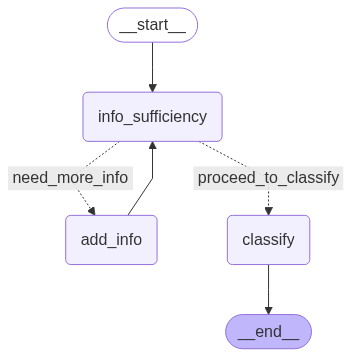

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Функция для запуска агента. Принимает датафрейм и агента. Возвращает размеченный датафрейм.

In [20]:
def agent_classifier(
    input_df: pd.DataFrame,
    agent,
    text_col: str = 'text',
    address_col: str = 'address',
    name_col: str = 'name',
    summary_col: str = 'summarized'
) -> pd.DataFrame:
    
    # Создаем временный уникальный ID для каждой строки
    input_df = input_df.copy()
    input_df['_temp_id'] = range(len(input_df))
    
    results = []
    
    for _, row in tqdm(input_df.iterrows(), total=len(input_df)):
        initial_state = {
            "user_query": row[text_col],
            "organization_address": row[address_col],
            "organization_name": row[name_col],
            "summary": row[summary_col],
            "sufficiency": [],
            "classification": "",
            "additional_info": "",
            "number_of_requests": 0,
            "subject_of_clarification": "",
            "search_query": ""
        }
        
        result = agent.invoke(initial_state)
        
        results.append({
            "_temp_id": row['_temp_id'],  # Сохраняем временный ID
            "sufficiency": result["sufficiency"],
            "classification": result["classification"],
            "additional_info": result["additional_info"],
            "subject_of_clarification": result["subject_of_clarification"],
            "search_query": result["search_query"]
        })

    results_df = pd.DataFrame(results)
    results_df['agent_cls'] = np.where(results_df['classification'].str.contains('irrelevant'), 0, 1)
    
    # Объединяем по временному ID
    merged_df = pd.merge(input_df, results_df, on='_temp_id', how='left')
    
    # Удаляем временную колонку
    merged_df = merged_df.drop(columns=['_temp_id'])
    
    return merged_df

In [38]:
eval_data_5.shape

(100, 6)

**Запускаем нашу функцию**

In [39]:
# Разметка через агента
labelled_df = agent_classifier(eval_data_5, app)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
labelled_df.to_excel('eval_5.xlsx')

In [49]:
# labelled_df

**сконкатенируем** назад в один файл, полученные датасеты

In [26]:
eval_1 = pd.read_excel('eval_1.xlsx')
eval_2 = pd.read_excel('eval_2.xlsx')
eval_3 = pd.read_excel('eval_3.xlsx')
eval_4 = pd.read_excel('eval_4.xlsx')
eval_5 = pd.read_excel('eval_5.xlsx')

In [28]:
classified_eval = pd.concat([eval_1, eval_2, eval_3, eval_4, eval_5], ignore_index=True)
classified_eval.drop('Unnamed: 0', axis=1, inplace=True)

Сохраним в отдельный файл итоговый результат, а затем считаем.

In [ ]:
# classified_eval.to_excel('gpt_4_1_final_agent.xlsx')

In [2]:
classified_eval = pd.read_excel('gpt_4_1_final_agent.xlsx')

**Смотрим метрику**  
- вверху на старой разметке
- внизу на новой.

In [4]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(classified_eval['relevance'], classified_eval['agent_cls'])
accuracy_new = accuracy_score(classified_eval['relevance_new'], classified_eval['agent_cls'])
print(f"Accuracy: {accuracy:.3f}", f"Accuracy_new: {accuracy_new:.3f}", sep='\n')

Accuracy: 0.640
Accuracy_new: 0.772


**Вывод**

Получено значение accuracy на уровне 77,2%.  
Агент обращается к поиску в интернете примерно в 30% процентах случаев.  
Запросы формируются в целом адекватно тому, что требуется уточнить.  
Большое значение имеет работа поисковика (в данном случае Tavily). Поскольку он в т.ч. агрегирует инфо могут встречаться случаи ошибки от Tavily. Возможно требуется создание доп инструмента парсинга сайтов из выдачи от Tavily.  

**Необходимо проанализировать** случаи ошибки агента. Нет ли ошибок в разметке. Соотнести случаи поиска в интернете и решения агента с учетом новой инфо, рассмотреть были ли ошибочные решения, рассмотреть случаи ошибки в разметке.  

**Основные выводы** по проекту будут представлены на страничке проекта в Github.